<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Stuff" data-toc-modified-id="Import-Stuff-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Stuff</a></span><ul class="toc-item"><li><span><a href="#NOTE" data-toc-modified-id="NOTE-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>NOTE</a></span></li><li><span><a href="#Anonymous-Functions" data-toc-modified-id="Anonymous-Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Anonymous Functions</a></span></li><li><span><a href="#Named-Functions" data-toc-modified-id="Named-Functions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Named Functions</a></span></li></ul></li><li><span><a href="#Convergence-Test" data-toc-modified-id="Convergence-Test-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Convergence Test</a></span><ul class="toc-item"><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></li><li><span><a href="#Potential-Maps-vs-Relative-Angle" data-toc-modified-id="Potential-Maps-vs-Relative-Angle-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Potential Maps vs Relative Angle</a></span><ul class="toc-item"><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></li><li><span><a href="#Compare-Zeroed-Antiferro-Maps" data-toc-modified-id="Compare-Zeroed-Antiferro-Maps-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Compare Zeroed Antiferro Maps</a></span><ul class="toc-item"><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></li></ul></div>

# Import Stuff

In [3]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter

sns.set(font_scale=1.5)
#sns.set_context("paper")

with open("tidy_data/pm_broad_sweep.pkl","rb") as _filein:
    raw_data = pkl.load(_filein)
    
raw_df = pd.DataFrame(raw_data)
raw_df.fill = raw_df.fill.apply(int)
raw_df.angle = raw_df.angle.apply(float)
raw_df.config = raw_df.config.apply(int)
raw_df.head()

,angle,config,energy,fill
0,0.0,0,-905.487915,1000
1,0.0,1,-905.487912,1000
2,0.0,10,-905.487957,1000
3,0.0,11,-905.487945,1000
4,0.0,12,-905.487929,1000


## NOTE

The convergence data is in this dataframe as well, and the information is encoded under `angle`.

- `angle` = 0.0001 $\rightarrow$ `EDIFF` = 1e-04
- `angle` = 1e-06 $\rightarrow$ `EDIFF` = 1e-06

## Anonymous Functions

In [4]:
filter_by_fill = lambda fill, df=raw_df: df[df.fill == fill]
filter_by_angle = lambda angle, df: df[df.angle == angle]

## Named Functions

In [84]:
def plot_map(fill=None,angle=None,ax=None):
    map_df = filter_by_angle(angle,filter_by_fill(fill))
    map_df.sort_values("config",axis=0,inplace=True)
    map_df.config *= np.pi/90
    sns.lineplot(x="config",y="energy",data=map_df,ax=ax,
                 label="Rel. Ang: {:.2f}".format(angle))

    
def plot_convergence_test():
    angle1 = 1e-04
    angle2 = 1e-06
    fill = 1010

    map_df = filter_by_angle(angle1,filter_by_fill(fill))
    map_df.sort_values("config",axis=0,inplace=True)
    map2_df = filter_by_angle(angle2,filter_by_fill(fill))
    map2_df.sort_values("config",axis=0,inplace=True)
    scale1 = np.pi/150
    scale2 = scale1
    map_df.config *= scale1
    map2_df.config *= scale2
    
#    fig = plt.figure(figsize=(12,8))
#    ax = plt.gca()
#    plt.plot(scale1*map_df.config.values,map_df.energy.values,
#                label="Fill: {}\nEDIFF: {}".format(fill,angle1))
#    plt.plot(scale1*map2_df.config.values,map2_df.energy.values,
#                label="Fill: {}\nEDIFF: {}".format(fill,angle2))
#    ax.legend()
#    ax.set(xlabel="Rotation [rad]",ylabel="Energy [eV]")
    
    fig = plt.figure(figsize=(12,9))
    gs = gridspec.GridSpec(nrows=2,ncols=1,figure=fig,hspace=0.5)
    ax = plt.subplot(gs[0,0])
    sns.barplot(x=map_df.config.values[:50],y=map_df.energy.values[:50]/map2_df.energy.values)
    ax.set(xlabel="Rotation [rad]",ylabel="Energy Ratio", ylim=[0.999,1.0001])
    labels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels([str(round(float(label), 2)) for label in labels])
    _ = [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % 4 != 0]
    ax.axhline(1.0,color='red',ls='--')
    ax2 = plt.subplot(gs[1,0])
    ax2.plot(map_df.config.values[:150],(map_df.energy.values[:150]-map_df.energy.values[0])*1000.)
    ax2.set(xlabel="Rotation [rad]",ylabel="Energy [meV]",xlim=[0,np.pi])
    
def plot_relative_angle():
    #angles = set(raw_df.angle.values)
    #angles.discard(1e-04) # Don't want to look at energy convergence stuff
    #angles.discard(1e-06)
    angles = [0.0, 0.5235987756, 1.0471975512, 1.5707963268, 2.0943951024, 2.617993878, 3.1415926536]
    angles.sort()

    fig = plt.figure(figsize=(12,9))
    ax = plt.gca()

    for i,ang in enumerate(angles):
        plot_map(fill=1010,angle=ang,ax=ax)

    ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
    ax.set(xlabel="Rotation Angle [rad]",ylabel="Energy [eV]")
    
def zero_energy(fill,angle=3.1415926536):
    df = filter_by_angle(angle, filter_by_fill(fill))
    df.sort_values("config",axis=0,inplace=True)
    zero_en = df.energy.values[0]
    df.energy -= zero_en
    scale = len(df.config)-1
    df.config *= np.pi/3/scale
    
    return df
def plot_zeroed_antiferro_comparison():
    fig = plt.figure(figsize=(16,12))
    ax = plt.gca()

    for fill in set(raw_df.fill.values):
        if fill == 1000:
            sns.lineplot(x="config",y="energy",data=zero_energy(fill,angle=0.0),ax=ax,label="Fill: {}".format(fill))
        else:
            sns.lineplot(x="config",y="energy",data=zero_energy(fill),ax=ax,label="Fill: {}".format(fill))

    ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
    ax.set(xlabel="Rotation Angle [rad]",ylabel="Energy [eV]")


# Convergence Test

First, we make sure that our value for EDIFF is appropriate by comparing the potential map for the following cases:

- **Fill**: 1010
- **Coupling**: Ferro
- **EDIFF**: 1e-04, 1e-06

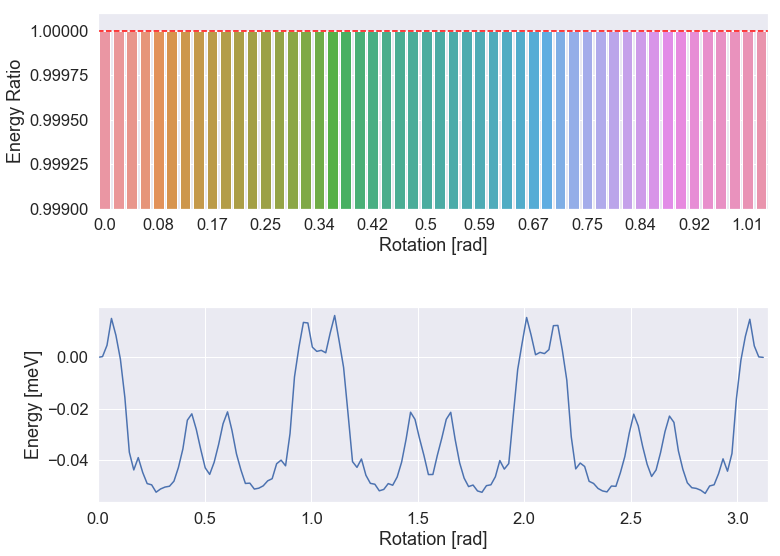

In [85]:
plot_convergence_test()

In [86]:
angle1 = 1e-04
angle2 = 1e-06
fill = 1010
scale1 = np.pi/150
scale2 = np.pi/150
map_df = filter_by_angle(angle1,filter_by_fill(fill))
map_df.sort_values("config",axis=0,inplace=True)
map2_df = filter_by_angle(angle2,filter_by_fill(fill))
map2_df.sort_values("config",axis=0,inplace=True)
map_df.config *= scale1
map2_df.config *= scale2



## Conclusions

1. EDIFF = 1-04 is sufficient


# Potential Maps vs Relative Angle

Now, look at potential maps for `fill` 1010 as a function of relative angle between the two water molecules. 

From interaction of dipoles in a vaccum

$$ V = p^2\cos\theta $$

it is expected that antiferro coupling ($\theta = \pi$) will be energetically most favorable.

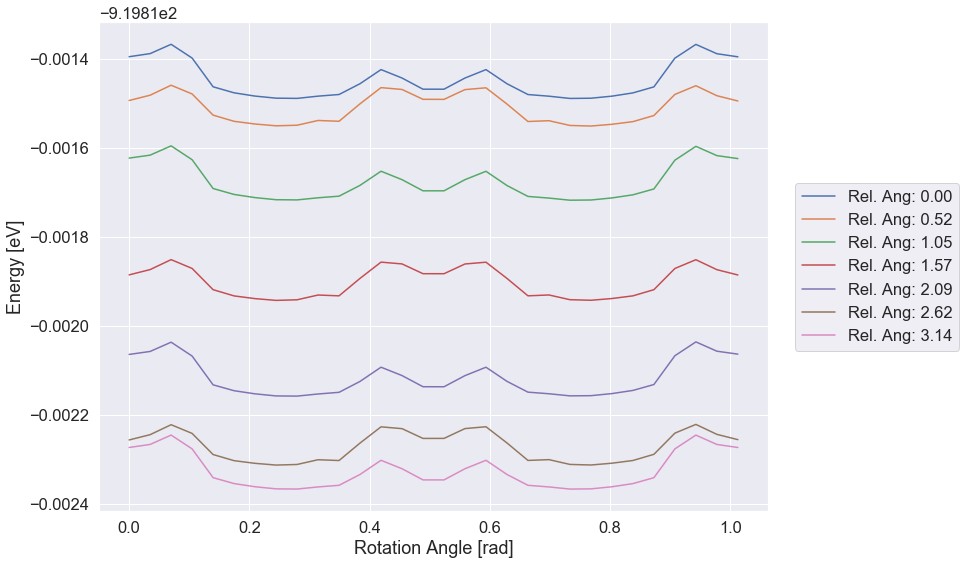

In [87]:
plot_relative_angle()


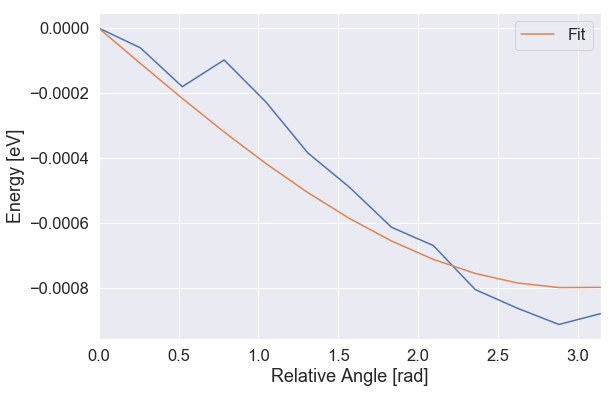

In [77]:
from scipy.optimize import curve_fit

def fit_func_sine(A,f):
    return -A*np.sin(f*x)
fill = 1010
angles = set(raw_df.angle.values)
angles.discard(1e-4)
angles.discard(1e-6)
x = list(angles)
x.sort()
x = np.array(x)

ens = []

for i,ang in enumerate(angles):
    df = filter_by_angle(ang,filter_by_fill(fill))
    df.sort_values("config",axis=0,inplace=True)
    ens.append(df.energy.values[0])
    
ens -= ens[0]
ens = np.array(ens)

popt, pcov = curve_fit(fit_func_sine, x, ens)

fig = plt.figure(figsize=(9,6))
ax = plt.gca()
ax.set(xlim=[0,np.pi],xlabel="Relative Angle [rad]", ylabel="Energy [eV]")
ax.plot(x,ens)
ax.plot(x,-0.0008*np.sin(np.pi/6*x),label="Fit")
ax.legend();
#ax.plot(xdata,fit_func_sine(x, *popt),label="Fit") # xdata needs to be there for some reasons
# ignore warning


In [78]:
len(df.angle.values)

30

## Conclusions

1. Overall, antiferro coupling is energetically preferred.


# Compare Zeroed Antiferro Maps

Here, each antiferro potential map is zeroed relative to the energy of the first position.


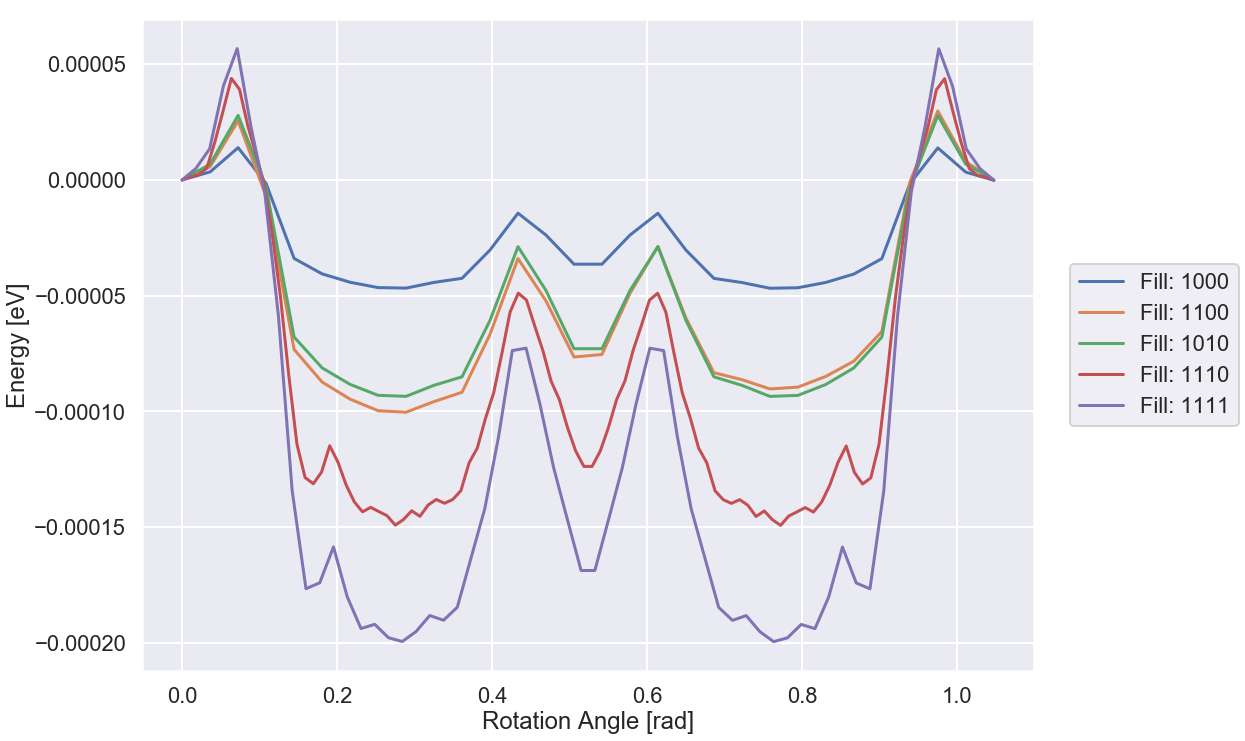

In [8]:
plot_zeroed_antiferro_comparison()

## Conclusions

1. Additional water molecules "deepen" potential map
2. Two 6-degenerate minima, one 12-degenerate minima
3. Sufficient to to scan $0\le \theta \le 0.6$ to capture all interesting features
    $\rightarrow$ fine sweep

In [23]:

df = filter_by_fill(1010,df=raw_df)


,angle,config,energy,fill
30,0.0,0,-919.811395,1010
31,0.0,1,-919.811388,1010
32,0.0,10,-919.811480,1010
33,0.0,11,-919.811455,1010
34,0.0,12,-919.811424,1010


In [42]:
df = filter_by_fill(1110)
df = df[df.angle == 3.1415926536]
df.sort_values("config")
with open("tidy_data/pmap_antiferro_1110.pkl", "wb") as file_out:
    pkl.dump(df,file_out)
    print("Dumped")

Dumped


In [41]:
rm tidy_data/pmap_antiferro_1010.pkl